In [1]:
import sys
import re
from collections import defaultdict
from pprint import pprint

WAV_FILE_PATH = 'data/waveforms.root'

import uproot

import numpy as np
from matplotlib import pyplot as plt

# Load file

In [2]:
SECTOR = 'sector 56'
STATION = 'station 220cyl'
RP = 'cyl_hr'

data_dir = f'wav/CTPPS/TimingDiamond/{SECTOR}/{STATION}/{RP}'

In [3]:
file_raw = uproot.open(WAV_FILE_PATH)

len(file_raw)

488401

In [4]:
len(file_raw[data_dir])

368237

In [5]:
file_raw[data_dir].keys()[:20]

['event 789278;1',
 'event 789278/plane 2;1',
 'event 789278/plane 2/channel 11;1',
 'event 789278/plane 2/channel 11/fpgaTimestamp;1',
 'event 789278/plane 2/channel 11/timestampA;1',
 'event 789278/plane 2/channel 11/timestampB;1',
 'event 789278/plane 2/channel 11/cellInfo;1',
 'event 789278/plane 2/channel 11/t0;1',
 'event 789278/plane 2/channel 11/wavCal;1',
 'event 524016;1',
 'event 524016/plane 0;1',
 'event 524016/plane 0/channel 2;1',
 'event 524016/plane 0/channel 2/fpgaTimestamp;1',
 'event 524016/plane 0/channel 2/timestampA;1',
 'event 524016/plane 0/channel 2/timestampB;1',
 'event 524016/plane 0/channel 2/cellInfo;1',
 'event 524016/plane 0/channel 2/t0;1',
 'event 524016/plane 0/channel 2/wavCal;1',
 'event 524016/plane 1;1',
 'event 524016/plane 1/channel 2;1']

In [6]:
sorted_events = sorted(file_raw[data_dir].keys(recursive=False), key=lambda x: int(x[6:-2]))
sorted_events[:20]

['event 3375;1',
 'event 6341;1',
 'event 7535;1',
 'event 8570;1',
 'event 9831;1',
 'event 9900;1',
 'event 10650;1',
 'event 11542;1',
 'event 13050;1',
 'event 14400;1',
 'event 15834;1',
 'event 15880;1',
 'event 17250;1',
 'event 17550;1',
 'event 18291;1',
 'event 19792;1',
 'event 20290;1',
 'event 22036;1',
 'event 23032;1',
 'event 24253;1']

# Produce dataset

In [7]:
class WaveformData:
    def __init__(self, series, fpga_timestamp, timestampA, timestampB, cell_info, t0):
        self.series = series
        self.t0 = t0
        self.fpga_timestamp = fpga_timestamp
        self.timestampA = timestampA
        self.timestampB = timestampB
        self.cell_info = cell_info
        
    @classmethod
    def from_channel_data(cls, channel_data):
        series = np.array(channel_data['wavCal'].values())
        fpga_timestamp = int(channel_data['fpgaTimestamp'].members['fTitle'])
        timestampA = int(channel_data['timestampA'].members['fTitle'])
        timestampB = int(channel_data['timestampB'].members['fTitle'])
        cell_info = int(channel_data['cellInfo'].members['fTitle'])
        t0 = float(channel_data['t0'].members['fTitle'])
        return cls(series, fpga_timestamp, timestampA, timestampB, cell_info, t0)
    
    def get_metadata_str(self):
        return {
            't0': self.t0,
            'fpga_timestamp': self.fpga_timestamp,
            'timestampA': self.timestampA,
            'timestampB': self.timestampB,
            'cell_info': self.cell_info
        }.__str__()
    
class EventData:
    def __init__(self, planes):
        self.planes = planes
        
    @classmethod
    def from_event_data(cls, event_data):
        planes = {}
        for plane_key, plane_data in event_data.items(recursive=False):
            plane_name = plane_key[6:-2]
            planes[plane_name] = {}
            for channel_key, channel_data in plane_data.items(recursive=False):
                channel_name = channel_key[8:-2]
                planes[plane_name][channel_name] = WaveformData.from_channel_data(channel_data)
        return cls(planes)
    
    def __str__(self):
        return {'plane ' + plane_name: {'channel ' + channel_name: f't0: {wav_data.t0}' for channel_name, wav_data in plane_data.items()} for plane_name, plane_data in self.planes.items()}.__str__()
    
    def get_metadata_dict(self):
        return {'plane ' + plane_name: {'channel ' + channel_name: wav_data.get_metadata_str() for channel_name, wav_data in plane_data.items()} for plane_name, plane_data in self.planes.items()}
    
    def get_plane_count(self):
        return len(self.planes)
    
    def get_hit_count(self):
        return sum(len(channels) for channels in self.planes.values())
    
    def get_all_waveforms(self):
        wavs = []
        for plane, channels in self.planes.items():
            for channel, wav_data in channels.items():
                wavs.append((plane, channel, wav_data))
                
        return wavs

In [8]:
dataset = {}

for event in sorted_events:
    event_int = int(event[6:-2])
    event_data = file_raw[data_dir][event]
    dataset[event_int] = EventData.from_event_data(event_data)

In [9]:
print(dataset[24253])

{'plane 0': {'channel 11': 't0: -11.016583'}, 'plane 1': {'channel 11': 't0: -0.722502'}, 'plane 2': {'channel 11': 't0: -0.389096'}, 'plane 3': {'channel 11': 't0: 1.989922'}}


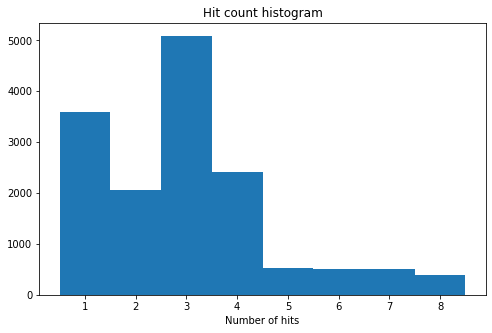

In [10]:
hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

plt.figure(figsize=(8, 5))
plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
plt.title('Hit count histogram')
plt.xlabel('Number of hits')
plt.show()

In [11]:
file_raw.close()

# Examples

In [12]:
events_to_view = []
for event, event_data in dataset.items():
    if event_data.get_plane_count() == 4 and event_data.get_hit_count() == 4:
        events_to_view.append(event)
    if len(events_to_view) == 8:
        break
        
events_to_view

[19792, 24253, 28186, 29933, 54450, 57600, 64950, 107178]

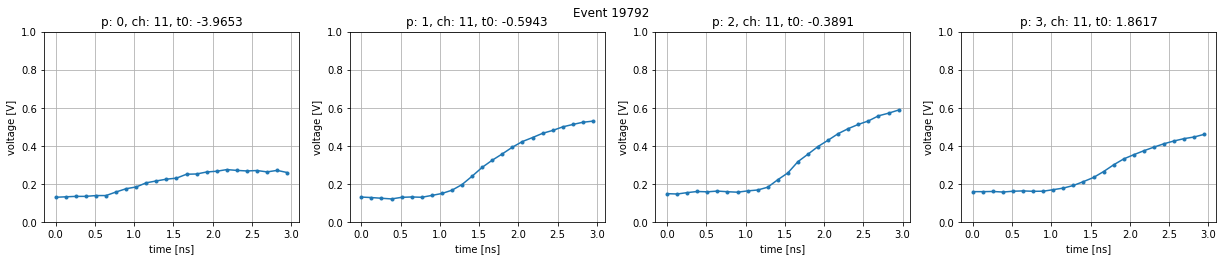

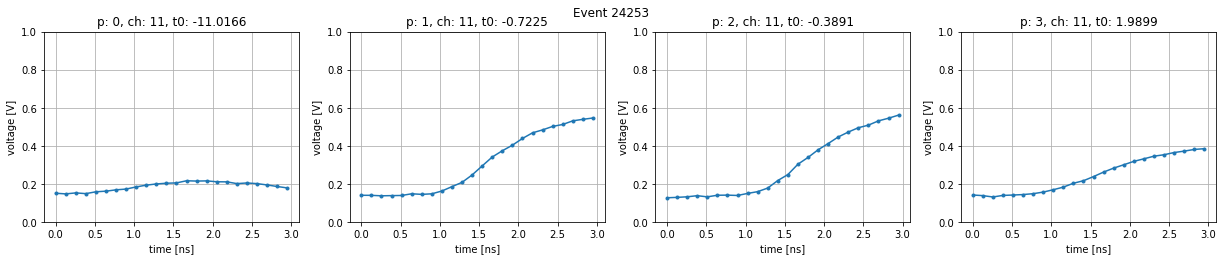

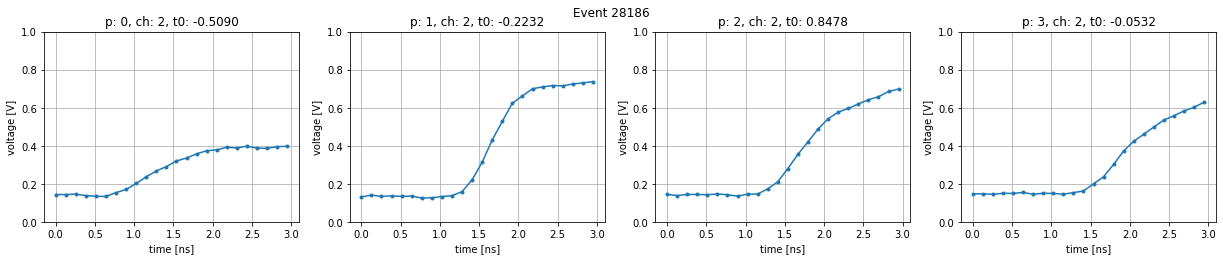

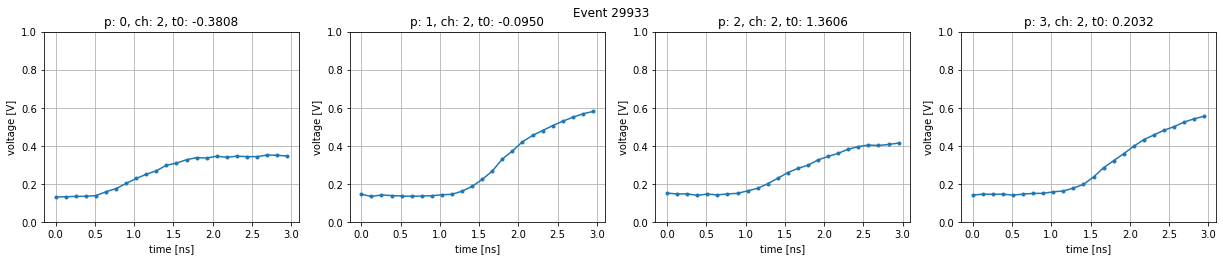

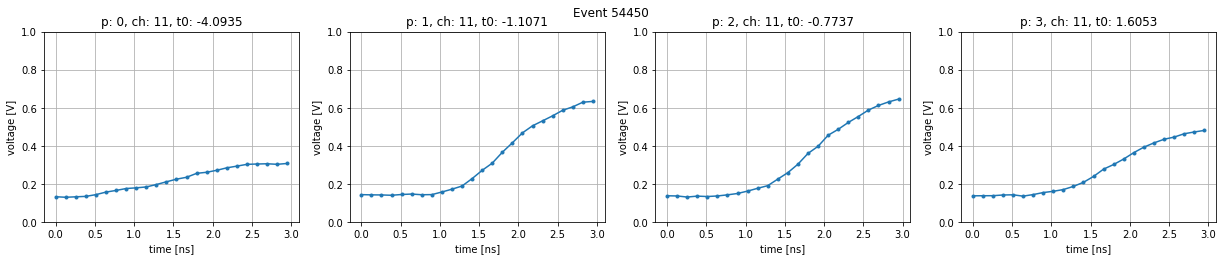

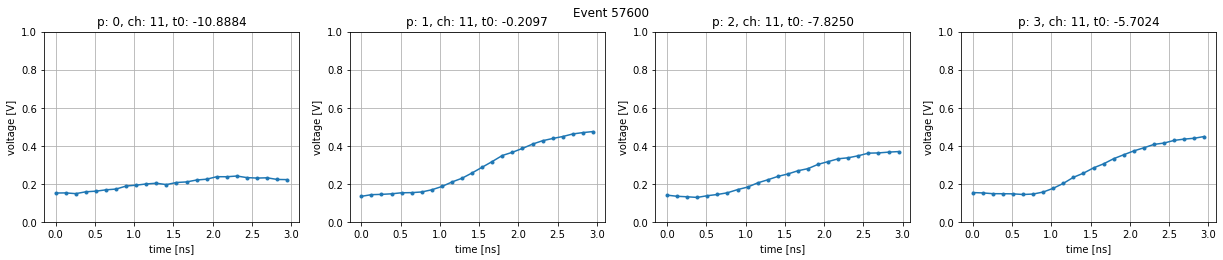

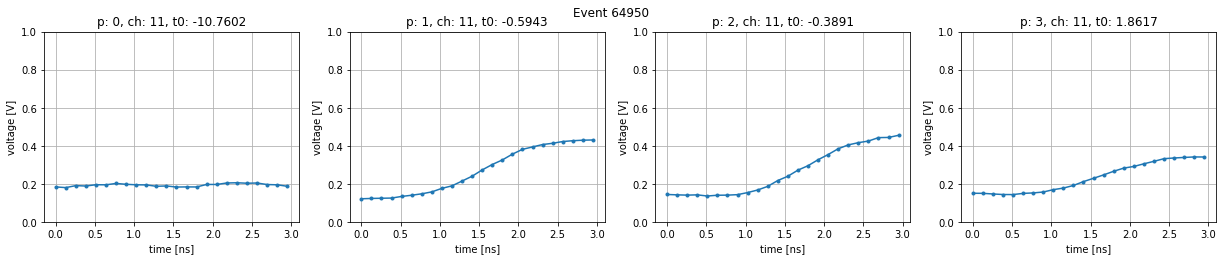

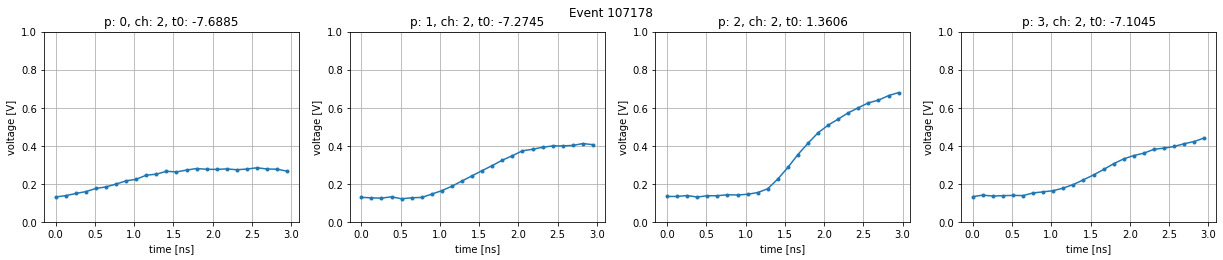

In [13]:
for event in events_to_view:
    plt.figure(figsize=(21, 3.5))
    
    for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
        plt.subplot(1, 4, i + 1)
        plt.plot(wav_data.series[0], -wav_data.series[1] + 1, marker='.')
        plt.ylim(0, 1)
        plt.title(f'p: {plane}, ch: {channel}, t0: {wav_data.t0:0.4f}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.grid()
    
    plt.suptitle(f'Event {event}')
    
    plt.show()

In [14]:
for event in events_to_view[:2]:
    print('Event:', event)
    pprint(dataset[event].get_metadata_dict())

Event: 19792
{'plane 0': {'channel 11': "{'t0': -3.965301, 'fpga_timestamp': 7264059, "
                           "'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 29}"},
 'plane 1': {'channel 11': "{'t0': -0.594297, 'fpga_timestamp': 7264031, "
                           "'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 24}"},
 'plane 2': {'channel 11': "{'t0': -0.389096, 'fpga_timestamp': 7264057, "
                           "'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 23}"},
 'plane 3': {'channel 11': "{'t0': 1.861718, 'fpga_timestamp': 7264030, "
                           "'timestampA': 1779, 'timestampB': 1778, "
                           "'cell_info': 25}"}}
Event: 24253
{'plane 0': {'channel 11': "{'t0': -11.016583, 'fpga_timestamp': 18041567, "
                           "'timestampA': 2739, 'timestampB': 2738, "
                           "'cell_info': 38}"},
 'plane 